# Transfer Learning On Xception Model

In [27]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.random.set_seed(1337)
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import tensorflow_datasets as tfds
import numpy as np
from keras.utils import plot_model

## Data Loading

In [26]:
train_ds , validation_ds , test_ds = tfds.load(
    "cats_vs_dogs" ,  # dataset name
    # reserving 10 % for validation and 10% for test
    split = ["train[:10%]" , "train[40%:50%]" , "train[50%:60%]"] ,
    as_supervised = True ,  #include labels as well
    
)

In [7]:
print("Number of training samples: " , tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: " , tf.data.experimental.cardinality(validation_ds))
print("Number of testing samples: " , tf.data.experimental.cardinality(test_ds))

Number of training samples:  tf.Tensor(2326, shape=(), dtype=int64)
Number of validation samples:  tf.Tensor(2326, shape=(), dtype=int64)
Number of testing samples:  tf.Tensor(2326, shape=(), dtype=int64)


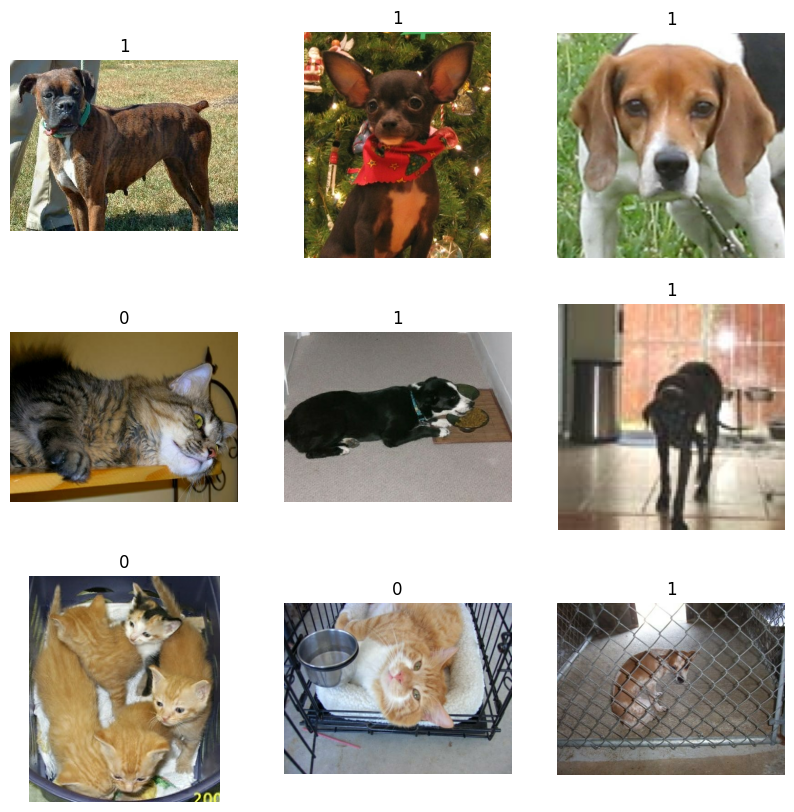

In [8]:
#looking through the dataset
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for i , (image , label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
    
#cats identified as 0 and dogs as 1

In [9]:
#resize the images to 150 * 150 to match input requirement of model
size = (150, 150)

# Define the resizing function
def resize_image(image, label):
    image = tf.image.resize(image, size)
    return image, label

# Apply the resizing function to each dataset
train_ds = train_ds.map(resize_image)
validation_ds = validation_ds.map(resize_image)
test_ds = test_ds.map(resize_image)


In [10]:
batch_size = 32

In [11]:
#prefetch data for optimized data loading
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size = 10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size = 10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size = 10)

## Data Augmentation

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#performing data augmentation for better accuracy

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


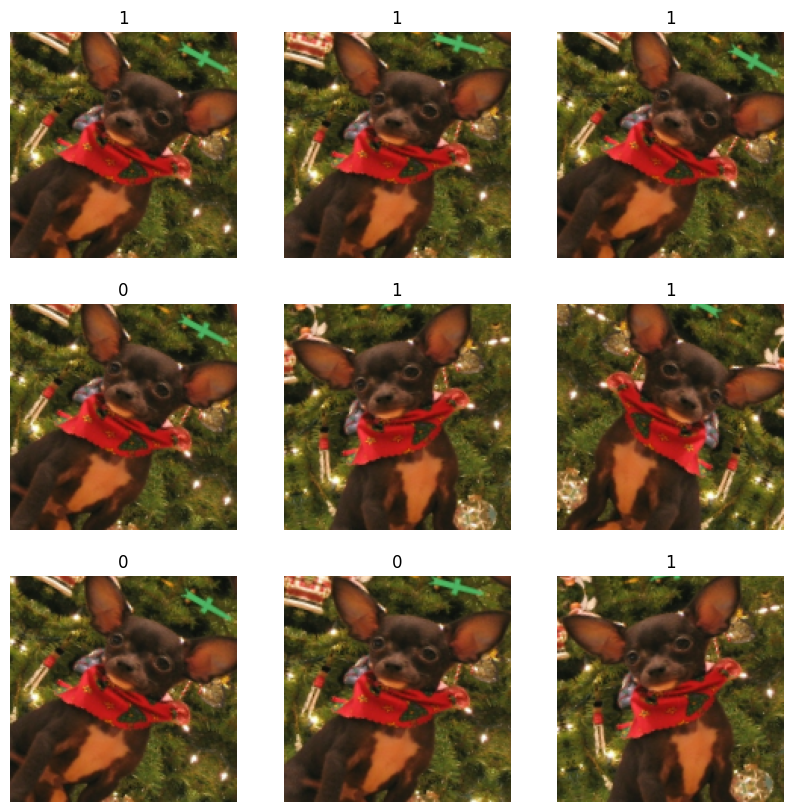

In [13]:
#visualizing the data
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Creating Model using Xception as Feature Extractor

In [14]:

#building the base model

base_model = keras.applications.Xception(
weights = None ,  #can be replaced with weights = 'None' if you want to train from scratch
    input_shape= (150 , 150 , 3) ,
    include_top = False , #get rid of classification layer, the descriminator
)
#create new model on top 
inputs = keras.Input(shape = (150 ,150 , 3))  #1st layer
x = data_augmentation(inputs) #random augmentation  #2nd layer



#the pretained xpcetion model weights requires the inputs to be normalized
# from (0,255) to a range(-1 ... +1) , the normalization layer
#scale inputs to [-1,+1]

scale_layer =  keras.layers.Rescaling(scale = 1/ 127.5 , offset = -1)
x = scale_layer(x)  #3rd layer



# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x)  # The x will output the feature vector  # 4th layer

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

# Assuming binary classification, use 'sigmoid'
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, output)


In [15]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [16]:
model.compile(
optimizer = keras.optimizers.Adam() ,
loss = keras.losses.BinaryCrossentropy(from_logits = True) ,
metrics = [keras.metrics.BinaryAccuracy()] ,)

In [17]:
epochs =  30

In [18]:
model.fit(train_ds , epochs = epochs , validation_data = validation_ds)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - binary_accuracy: 0.5671 - loss: 0.7804 - val_binary_accuracy: 0.4948 - val_loss: 0.6932
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.6193 - loss: 0.6716 - val_binary_accuracy: 0.5052 - val_loss: 0.6931
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.6607 - loss: 0.6312 - val_binary_accuracy: 0.5052 - val_loss: 0.6930
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.6633 - loss: 0.6287 - val_binary_accuracy: 0.5052 - val_loss: 0.6929
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - binary_accuracy: 0.6711 - loss: 0.6060 - val_binary_accuracy: 0.5052 - val_loss: 0.6917
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - binary_accuracy: 0.6841 - loss: 0.5956 - val_binary_accuracy: 0.5052 - val_loss: 0.6927
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - binary_accuracy: 0.7098 - loss: 0.5901 - val_binary_accuracy: 0.6887 - val_loss: 0.6074

# Now Using the pretrained weights instead of training from Scratch

In [19]:

base_model = keras.applications.Xception(
weights = 'imagenet' ,  #can be replaced with weights = 'None' if you want to train from scratch
    input_shape= (150 , 150 , 3) ,
    include_top = False , #get rid of classification layer, the descriminator
)
#create new model on top 
inputs = keras.Input(shape = (150 ,150 , 3))  #1st layer
x = data_augmentation(inputs) #random augmentation  #2nd layer


base_model.trainable = False   # no weight updation


scale_layer =  keras.layers.Rescaling(scale = 1/ 127.5 , offset = -1)
x = scale_layer(x)  #3rd layer



x = base_model(x , training = False) #no batchnormalization performed 
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

# Assuming binary classification, use 'sigmoid'
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, output)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [20]:
model.compile(
optimizer = keras.optimizers.Adam() ,
loss = keras.losses.BinaryCrossentropy(from_logits = True) ,
metrics = [keras.metrics.BinaryAccuracy()] ,)

In [21]:
epochs =  5

In [22]:
model.fit(train_ds , epochs = epochs , validation_data = validation_ds) #the training now takes half of the time

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - binary_accuracy: 0.8022 - loss: 0.3926 - val_binary_accuracy: 0.9579 - val_loss: 0.1112
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - binary_accuracy: 0.9361 - loss: 0.1653 - val_binary_accuracy: 0.9682 - val_loss: 0.0924
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - binary_accuracy: 0.9372 - loss: 0.1535 - val_binary_accuracy: 0.9699 - val_loss: 0.0854
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - binary_accuracy: 0.9407 - loss: 0.1320 - val_binary_accuracy: 0.9703 - val_loss: 0.0821
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - binary_accuracy: 0.9437 - loss: 0.1298 - val_binary_accuracy: 0.9708 - val_loss: 0.0805


## Fine Tuning by adding new trainable parameters to already pretained model

In [23]:
# since we passed `training=False` when calling it. This means the batchnorm layers will not update their batch statistics.


# dense_4 (Dense)                 │ (None, 1)              │         2,049 (trainable parameters)
base_model.trainable = True # new weights can be learned which were not present in pretrained weights (updating trainable parameter )
model.summary()

model.compile(
    optimizer = keras.optimizers.Adam(1e-5),  # Low learning rate
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

In [24]:
epochs = 5

In [25]:
model.fit(train_ds , epochs = epochs , validation_data = validation_ds) #the training now takes half of the time and better accuracy

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - binary_accuracy: 0.7841 - loss: 0.4128 - val_binary_accuracy: 0.9566 - val_loss: 0.1037
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.8854 - loss: 0.2996 - val_binary_accuracy: 0.9527 - val_loss: 0.1186
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.9156 - loss: 0.2344 - val_binary_accuracy: 0.9540 - val_loss: 0.1177
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.9377 - loss: 0.1922 - val_binary_accuracy: 0.9570 - val_loss: 0.1128
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - binary_accuracy: 0.9510 - loss: 0.1625 - val_binary_accuracy: 0.9592 - val_loss: 0.1063
